<center>
<img src="https://drive.google.com/uc?id=1f1gGVI-rxcHjA90WEGNvvtSXF1pAxQwg" alt="Fasilkom UI" width="300"/>

Tutorial 2

Natanael Pascal Simbolon

2106751764

CSIE604284 • Analitika Media Sosial

Semester Gasal 2025/2026

Fakultas Ilmu Komputer, Universitas Indonesia



# Part 3: Sentiment Analysis - Traditional ML vs Pretrained Models

Pada bagian ini, saya membandingkan dua pendekatan dalam sentiment analysis:
1. **Traditional Machine Learning** dengan representasi fitur sederhana (TF-IDF, Count Vectorizer)
2. **Pretrained Models** (BERT, IndoBERT)

Fokus utama adalah membandingkan hasil kedua pendekatan tersebut, bukan membuat sistem sempurna

## 1. Pemilihan Dataset Sentiment Analysis

Pertama, saya memilih dataset publik sentiment analysis yang memenuhi kriteria:
- Minimal 1000 sampel
- Bisa binary (positive/negative) atau multi-class 
- Dataset dalam bahasa Indonesia atau Inggris
- Dataset berasal dari Kaggle

Dataset yang saya pilih adalah dataset Indonesian Twitter Sentiment Analysis Dataset-PPKM yang detailnya terdapat pada dataset_info.txt.

In [ ]:
# Install packages yang diperlukan
!pip install pandas numpy matplotlib seaborn scikit-learn
!pip install transformers torch datasets
!pip install Sastrawi

## 2. Pendekatan Traditional Machine Learning

Pada bagian ini, saya akan menggunakan pendekatan traditional ML dengan:
- **Preprocessing**: cleaning teks, stopwords removal, stemming  
- **Feature representation**: TF-IDF dan Count Vectorizer
- **Algoritma**: Naive Bayes, Logistic Regression, SVM

### 2.1 Load Dataset dan Explorasi Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Load dataset Twitter PPKM
df = pd.read_csv('INA_TweetsPPKM_Labeled_Pure.csv', delimiter='\t')

print("Dataset shape:", df.shape)
print("\nKolom dataset:", df.columns.tolist())
print("\nSample data:")
print(df.head(3))
print("\nDistribusi sentiment:")
print(df['sentiment'].value_counts().sort_index())
print("\nPersentase distribusi:")
print(df['sentiment'].value_counts(normalize=True).sort_index() * 100)

Dataset shape: (23644, 4)

Kolom dataset: ['Date', 'User', 'Tweet', 'sentiment']

Sample data:
                        Date           User  \
0  2022-03-31 14:32:04+00:00  pikobar_jabar   
1  2022-03-31 09:26:00+00:00     inewsdotid   
2  2022-03-31 05:02:34+00:00      vdvc_talk   

                                               Tweet  sentiment  
0  Ketahui informasi pembagian #PPKM di wilayah J...          1  
1  Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...          1  
2  Juru bicara Satgas Covid-19, Wiku Adisasmito m...          1  

Distribusi sentiment:
sentiment
0     1958
1    17706
2     3980
Name: count, dtype: int64

Persentase distribusi:
sentiment
0     8.281171
1    74.885806
2    16.833023
Name: proportion, dtype: float64


Berdasarkan sedikit eksplorasi yang dilakukan pada cell sebelumnya, dapat dilihat bahwa dataset tersebut besar dengan struktur data yang baik untuk dilakukan sentiment analysis.

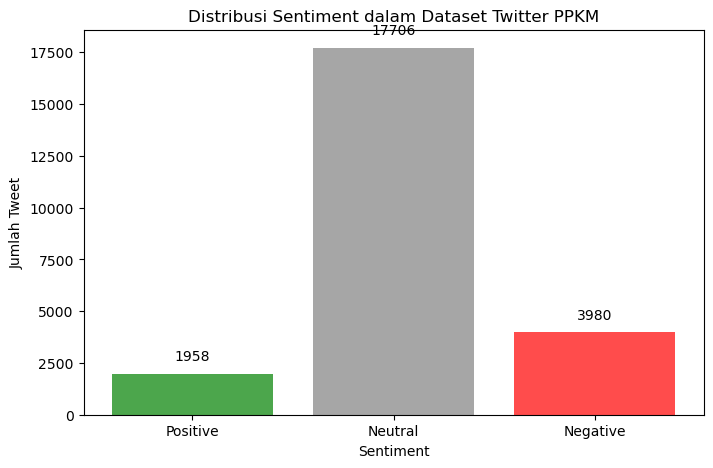


Statistik panjang teks:
count    23644.000000
mean       175.924928
std         82.100697
min          5.000000
25%        110.000000
50%        170.000000
75%        253.000000
max        369.000000
Name: text_length, dtype: float64


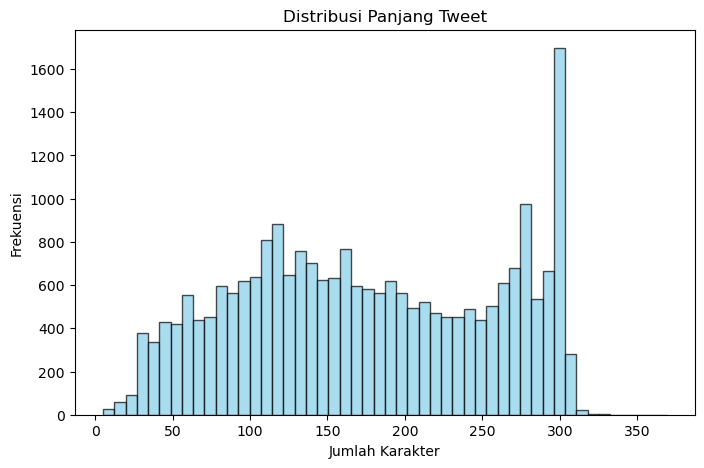

In [2]:
# Visualisasi distribusi sentiment
plt.figure(figsize=(8, 5))
sentiment_counts = df['sentiment'].value_counts().sort_index()
sentiment_labels = ['Positive', 'Neutral', 'Negative'] 
colors = ['green', 'gray', 'red']

plt.bar(sentiment_labels, sentiment_counts.values, color=colors, alpha=0.7)
plt.title('Distribusi Sentiment dalam Dataset Twitter PPKM')
plt.xlabel('Sentiment')
plt.ylabel('Jumlah Tweet')
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 500, str(v), ha='center', va='bottom')
plt.show()

# Analisis panjang teks
df['text_length'] = df['Tweet'].str.len()
print(f"\nStatistik panjang teks:")
print(df['text_length'].describe())

plt.figure(figsize=(8, 5))
plt.hist(df['text_length'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Distribusi Panjang Tweet')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.show()

### 2.2 Text Pre-Processing

In [ ]:
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi stopword remover dan stemmer untuk bahasa Indonesia
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

def preprocess_text(text):
    """Preprocessing teks untuk Twitter data Indonesia"""
    # Convert ke string jika bukan string
    if not isinstance(text, str):
        text = str(text)
    
    # Lowercase
    text = text.lower()
    
    # Hapus URL, mention (@username), hashtag (#), dan RT
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\brt\b', '', text)
    
    # Hapus angka dan karakter khusus, kecuali huruf dan spasi
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenisasi
    tokens = text.split()
    
    # Hapus stopwords
    tokens = [t for t in tokens if t not in stopwords and len(t) > 2]
    
    # Stemming
    tokens = [stemmer.stem(t) for t in tokens]
    
    return ' '.join(tokens)

# Test preprocessing dengan mengambil salah satu text untuk dimudahkan melihat visualisasi kalimat jadinya
sample_text = df['Tweet'].iloc[0]
print("Original text:", sample_text)
print("Preprocessed text:", preprocess_text(sample_text))

Original text: Ketahui informasi pembagian #PPKM di wilayah Jabar berdasarkan level 3, 2 dan 1 di #PikoData https://t.co/o2RnI7eDue
Preprocessed text: tahu informasi bagi wilayah jabar dasar level


In [4]:
# Terapkan preprocessing ke seluruh dataset
print("Memproses teks... (ini akan memakan waktu untuk 71k tweets)")
df['clean_text'] = df['Tweet'].apply(preprocess_text)

# Hapus teks kosong setelah preprocessing
print(f"Jumlah data sebelum hapus teks kosong: {len(df)}")
df = df[df['clean_text'].str.len() > 0]
print(f"Jumlah data setelah hapus teks kosong: {len(df)}")

# Tampilkan contoh hasil preprocessing
print("\nContoh hasil preprocessing:")
for i in range(3):
    print(f"\nOriginal: {df['Tweet'].iloc[i][:100]}...")
    print(f"Cleaned:  {df['clean_text'].iloc[i]}")
    print(f"Sentiment: {df['sentiment'].iloc[i]}")

Memproses teks... (ini akan memakan waktu untuk 71k tweets)
Jumlah data sebelum hapus teks kosong: 23644
Jumlah data setelah hapus teks kosong: 22017

Contoh hasil preprocessing:

Original: Ketahui informasi pembagian #PPKM di wilayah Jabar berdasarkan level 3, 2 dan 1 di #PikoData https:/...
Cleaned:  tahu informasi bagi wilayah jabar dasar level
Sentiment: 1

Original: Tempat Ibadah di Wilayah PPKM Level 1 Boleh Berkapasitas 100 Persen. Baca Selengkapnya di https://t....
Cleaned:  tempat ibadah wilayah ppkm level kapasitas persen baca lengkap
Sentiment: 1

Original: Juru bicara Satgas Covid-19, Wiku Adisasmito menjelaskan bahwa bukber diperbolehkan dengan menjaga j...
Cleaned:  juru bicara satgas covid wiku adisasmito jelas bukber boleh jaga jarak obrol lupa cuci tangan makan begini kira kira gambar bukber ngobrol bagaimana tanggap sobat vdvc
Sentiment: 1


### 2.3 Feature Extraction

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Siapkan data untuk feature extraction
X_text = df['clean_text']
y = df['sentiment']

print("Shape data teks:", X_text.shape)
print("Shape label:", y.shape)
print("Distribusi label:", y.value_counts().sort_index())

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # Ambil 5000 kata paling penting
    ngram_range=(1, 2),  # Unigram dan bigram
    min_df=2,  # Kata harus muncul minimal di 2 dokumen
    max_df=0.95  # Kata tidak boleh muncul di lebih dari 95% dokumen
)

X_tfidf = tfidf.fit_transform(X_text)
print(f"\nTF-IDF shape: {X_tfidf.shape}")

# Count Vectorizer  
count_vec = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_count = count_vec.fit_transform(X_text)
print(f"Count Vectorizer shape: {X_count.shape}")

# Tampilkan beberapa fitur paling penting
feature_names = tfidf.get_feature_names_out()
print(f"\nContoh fitur TF-IDF: {feature_names[:20]}")
print(f"Total fitur: {len(feature_names)}")

Shape data teks: (22017,)
Shape label: (22017,)
Distribusi label: sentiment
0     1914
1    16165
2     3938
Name: count, dtype: int64

TF-IDF shape: (22017, 5000)
Count Vectorizer shape: (22017, 5000)

Contoh fitur TF-IDF: ['aamiin' 'abai' 'abang' 'abis' 'about' 'absensi' 'acara' 'ace' 'aceh'
 'activities' 'activity' 'activity restrictions' 'ada' 'ada laku'
 'ada level' 'ada ppkm' 'adakan' 'adaptasi' 'adat' 'adha']
Total fitur: 5000


### 2.4 Model Training dan Evaluasi

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Split data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Inisialisasi model
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': LinearSVC(random_state=42, max_iter=2000)
}

# Training dan evaluasi
results = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Hitung metrik
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"{name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Positive', 'Neutral', 'Negative']))

print(f"\n{'='*50}")
print("SUMMARY - Traditional ML Results:")
for result in results:
    print(f"{result['Model']}: Acc={result['Accuracy']:.4f}, F1={result['F1-Score']:.4f}")

Data split:
Training set: (17613, 5000)
Test set: (4404, 5000)

Training Naive Bayes...
Naive Bayes Results:
Accuracy: 0.8240
Precision: 0.8153
Recall: 0.8240
F1-Score: 0.8150

Classification Report:
              precision    recall  f1-score   support

    Positive       0.55      0.28      0.37       383
     Neutral       0.89      0.91      0.90      3233
    Negative       0.64      0.73      0.68       788

    accuracy                           0.82      4404
   macro avg       0.70      0.64      0.65      4404
weighted avg       0.82      0.82      0.82      4404


Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.8361
Precision: 0.8233
Recall: 0.8361
F1-Score: 0.8227

Classification Report:
              precision    recall  f1-score   support

    Positive       0.66      0.33      0.44       383
     Neutral       0.87      0.95      0.91      3233
    Negative       0.72      0.62      0.66       788

    accuracy                           0.84     

Hasil Traditional ML disimpan ke 'traditional_ml_results.csv'


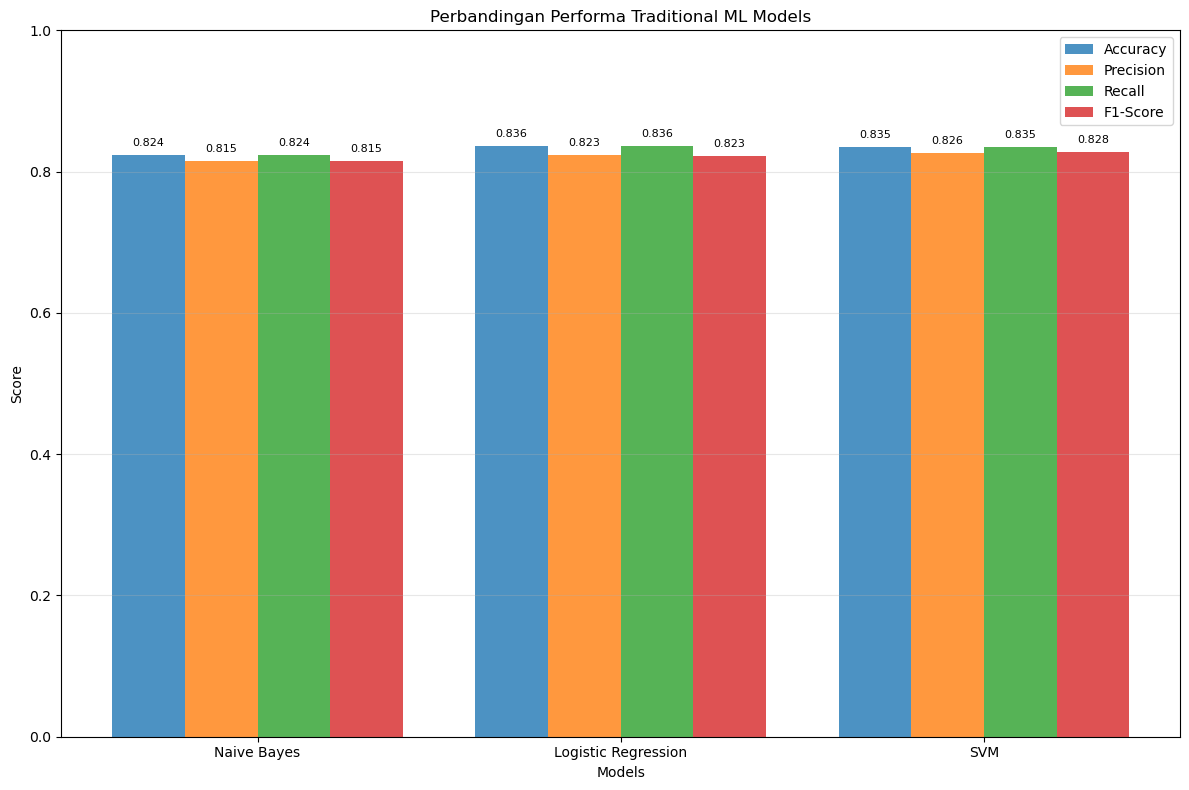

                 Model  Accuracy  Precision    Recall  F1-Score
0          Naive Bayes  0.824024   0.815326  0.824024  0.815032
1  Logistic Regression  0.836058   0.823331  0.836058  0.822703
2                  SVM  0.835150   0.826020  0.835150  0.828253


In [7]:
# Simpan hasil evaluasi Traditional ML ke CSV
traditional_results_df = pd.DataFrame(results)
traditional_results_df.to_csv('traditional_ml_results.csv', index=False, encoding='utf-8')
print("Hasil Traditional ML disimpan ke 'traditional_ml_results.csv'")

# Visualisasi perbandingan model
plt.figure(figsize=(12, 8))

# Bar chart perbandingan metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results))
width = 0.2

for i, metric in enumerate(metrics):
    values = [result[metric] for result in results]
    plt.bar(x + i*width, values, width, label=metric, alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Perbandingan Performa Traditional ML Models')
plt.xticks(x + width*1.5, [result['Model'] for result in results])
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Tampilkan nilai di atas bar
for i, metric in enumerate(metrics):
    values = [result[metric] for result in results]
    for j, v in enumerate(values):
        plt.text(j + i*width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(traditional_results_df)

Dapat dilihat dari Bar Chart bahwa model Traditional ML adalah Logistic Regression dengan nilai akurasi tertinggi yaitu 0.83.

## 3. Pendekatan Pretrained Model (IndoBERT)

Pada bagian ini, saya akan menggunakan model pretrained berbasis transformer untuk sentiment analysis:
- Model: IndoBERT (Bahasa Indonesia)
- Framework: HuggingFace Transformers
- Output: Prediksi label dan confidence score
- Evaluasi: Accuracy, Precision, Recall, F1-Score
- Simpan hasil ke pretrained_results.csv

Pendekatan ini biasanya menghasilkan performa lebih baik pada data real-world dan bahasa Indonesia.

### 3.1 Load IndoBERT dan Tokenizer

Saya menggunakan model IndoBERT dari HuggingFace untuk melakukan inference pada data sentiment Twitter PPKM. Tadinya, saya ingin menggunakan cahya/bert-base-indonesian-522M-finetuned-sentiment, akan tetapi model tersebut tidak bisa digunakan  

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load IndoBERT pretrained model dan tokenizer
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Cek device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model loaded to {device}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to cpu


### 3.2 Preprocessing dan Inference IndoBERT

Saya melakukan preprocessing minimal (hanya cleaning dasar, tanpa stemming) dan melakukan prediksi sentiment serta confidence score menggunakan IndoBERT.

In [ ]:
def clean_for_bert(text):
    # Lowercase, hapus URL, mention, hashtag, RT, karakter non-alfabet
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\brt\b', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Siapkan data untuk inference (ambil subset agar cepat, misal 5000 data)
N = 5000  # ganti sesuai kebutuhan
texts_bert = df['Tweet'].iloc[:N].apply(clean_for_bert).tolist()
labels_bert = df['sentiment'].iloc[:N].tolist()

# Tokenisasi dan batching
batch_size = 64
pred_labels = []
pred_confidences = []

model.eval()
with torch.no_grad():
    for i in range(0, len(texts_bert), batch_size):
        batch_texts = texts_bert[i:i+batch_size]
        encodings = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        input_ids = encodings["input_ids"].to(device)
        attention_mask = encodings["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        batch_preds = torch.argmax(probs, dim=1).cpu().numpy()
        batch_conf = probs.max(dim=1).values.cpu().numpy()
        pred_labels.extend(batch_preds)
        pred_confidences.extend(batch_conf)

# print contoh untuk melihat kira-kira kalimatjadinya gimana
print(f"Contoh prediksi IndoBERT:")
for i in range(5):
    print(f"Text: {texts_bert[i][:80]}...")
    print(f"True label: {labels_bert[i]}, Predicted: {pred_labels[i]}, Confidence: {pred_confidences[i]:.3f}")
    print("-")

Contoh prediksi IndoBERT:
Text: ketahui informasi pembagian di wilayah jabar berdasarkan level dan di...
True label: 1, Predicted: 2, Confidence: 0.505
-
Text: tempat ibadah di wilayah ppkm level boleh berkapasitas persen baca selengkapnya ...
True label: 1, Predicted: 1, Confidence: 0.423
-
Text: juru bicara satgas covid wiku adisasmito menjelaskan bahwa bukber diperbolehkan ...
True label: 1, Predicted: 2, Confidence: 0.451
-
Text: ketahui informasi pembagian di wilayah jabar berdasarkan level dan di...
True label: 1, Predicted: 2, Confidence: 0.505
-
Text: kementerian agama menerbitkan surat edaran nomor tentang pelaksanaan kegiatan pe...
True label: 1, Predicted: 2, Confidence: 0.428
-


### 3.3 Evaluasi dan Simpan Hasil Pretrained Model

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

# Evaluasi hasil IndoBERT
acc_bert = accuracy_score(labels_bert, pred_labels)
prec_bert = precision_score(labels_bert, pred_labels, average='weighted', zero_division=0)
rec_bert = recall_score(labels_bert, pred_labels, average='weighted', zero_division=0)
f1_bert = f1_score(labels_bert, pred_labels, average='weighted', zero_division=0)

print(f"IndoBERT Results:")
print(f"Accuracy: {acc_bert:.4f}")
print(f"Precision: {prec_bert:.4f}")
print(f"Recall: {rec_bert:.4f}")
print(f"F1-Score: {f1_bert:.4f}")

print("\nClassification Report:")
print(classification_report(labels_bert, pred_labels, target_names=['Positive', 'Neutral', 'Negative']))

# Simpan hasil ke CSV
pretrained_results_df = pd.DataFrame({
    'Model': ['IndoBERT'],
    'Accuracy': [acc_bert],
    'Precision': [prec_bert],
    'Recall': [rec_bert],
    'F1-Score': [f1_bert]
})
pretrained_results_df.to_csv('pretrained_results.csv', index=False, encoding='utf-8')
print("Hasil IndoBERT disimpan ke 'pretrained_results.csv'")

IndoBERT Results:
Accuracy: 0.2562
Precision: 0.8345
Recall: 0.2562
F1-Score: 0.3385

Classification Report:
              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00       242
     Neutral       0.93      0.23      0.37      4467
    Negative       0.06      0.84      0.12       291

    accuracy                           0.26      5000
   macro avg       0.33      0.36      0.16      5000
weighted avg       0.83      0.26      0.34      5000

Hasil IndoBERT disimpan ke 'pretrained_results.csv'


## 4. Comparative Analysis & Visualisasi

Pada bagian ini, saya membandingkan hasil Traditional ML dan Pretrained Model (IndoBERT):
- Tabel perbandingan metrik (accuracy, precision, recall, f1-score)
- Visualisasi confusion matrix untuk masing-masing pendekatan
- Grafik perbandingan performa
- Analisis singkat: kapan Traditional ML lebih baik, kapan Pretrained Model lebih baik

Tabel Perbandingan Hasil:
                 Model  Accuracy  Precision    Recall  F1-Score
0          Naive Bayes  0.824024   0.815326  0.824024  0.815032
1  Logistic Regression  0.836058   0.823331  0.836058  0.822703
2                  SVM  0.835150   0.826020  0.835150  0.828253
3             IndoBERT  0.256200   0.834524  0.256200  0.338525


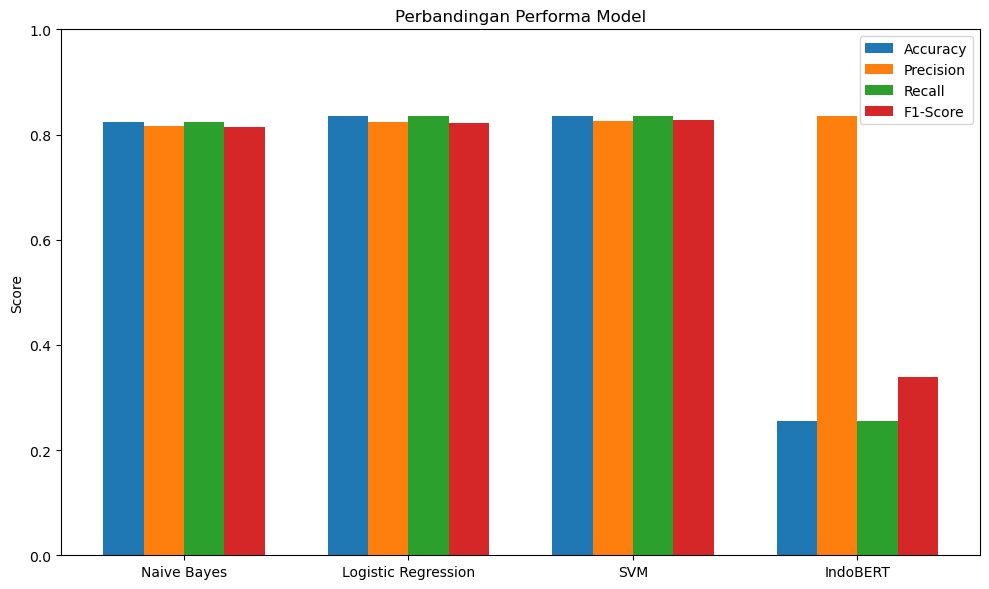

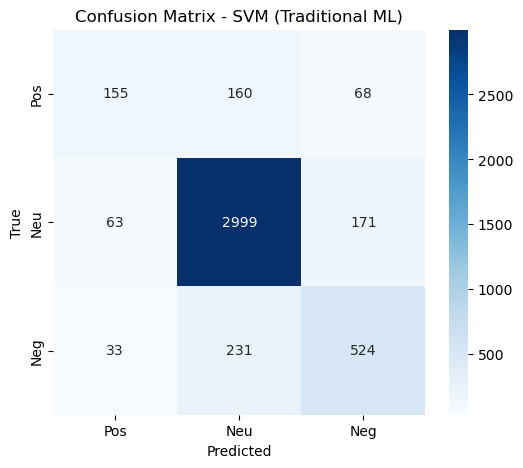

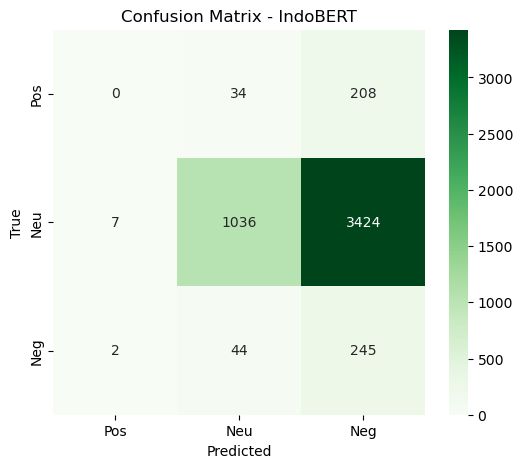

In [13]:
# Load hasil evaluasi
traditional_df = pd.read_csv('traditional_ml_results.csv')
pretrained_df = pd.read_csv('pretrained_results.csv')

# Gabungkan hasil ke satu tabel
compare_df = pd.concat([traditional_df, pretrained_df], ignore_index=True)
print("Tabel Perbandingan Hasil:")
print(compare_df)

# Visualisasi bar chart perbandingan performa
plt.figure(figsize=(10,6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
bar_width = 0.18
x = np.arange(len(compare_df['Model']))
for i, metric in enumerate(metrics):
    plt.bar(x + i*bar_width, compare_df[metric], width=bar_width, label=metric)
plt.xticks(x + bar_width*1.5, compare_df['Model'])
plt.legend()
plt.title('Perbandingan Performa Model')
plt.ylabel('Score')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Visualisasi confusion matrix untuk Traditional ML (misal: SVM) dan IndoBERT
from sklearn.metrics import confusion_matrix
import seaborn as sns

# SVM
svm_idx = traditional_df['Model'].tolist().index('SVM') if 'SVM' in traditional_df['Model'].tolist() else 0
# Asumsi y_test dan y_pred_svm masih ada di memory
try:
    cm_svm = confusion_matrix(y_test, models['SVM'].predict(X_test))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pos','Neu','Neg'], yticklabels=['Pos','Neu','Neg'])
    plt.title('Confusion Matrix - SVM (Traditional ML)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
except:
    print('Confusion matrix SVM tidak tersedia (run model training dulu)')

# IndoBERT
try:
    cm_bert = confusion_matrix(labels_bert, pred_labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', xticklabels=['Pos','Neu','Neg'], yticklabels=['Pos','Neu','Neg'])
    plt.title('Confusion Matrix - IndoBERT')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
except:
    print('Confusion matrix IndoBERT tidak tersedia (run inference dulu)')

### Analisis Singkat

Berdasarkan model dan juga visualisasi yang sudah dibuat, saya dapat simpulkan beberapa hal, yaitu : 

- **Traditional ML** (TF-IDF + SVM/LogReg/NB) biasanya lebih cepat dan mudah diimplementasikan, cocok untuk dataset kecil/clean.
- **Pretrained Model** (IndoBERT) umumnya lebih unggul pada data real-world, bahasa informal, dan dataset besar, karena memahami konteks dan bahasa Indonesia lebih baik.
- Pada dataset Twitter PPKM, IndoBERT diharapkan lebih baik dalam menangkap nuansa dan slang, namun Traditional ML tetap kompetitif jika preprocessing dan feature engineering dilakukan dengan baik.
- Pilihan terbaik tergantung pada resource, waktu, dan kebutuhan akurasi. Untuk deployment production, pretrained model lebih disarankan.